In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install opencv-python-headless==4.1.2.30
!pip install kaggle
!pip install -U albumentations
!pip install wandb
!pip install torchmetrics
!pip install segmentation_models_pytorch
!pip install torchsummary

In [ ]:
from collections import defaultdict, namedtuple
from itertools import product
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import os
import scipy.io as io
import cv2
import wandb
from tqdm.notebook import tqdm

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics import MeanMetric

import segmentation_models_pytorch as sm
from torchsummary import summary

In [ ]:
%env WANDB_SILENT=True
wandb.login()

env: WANDB_SILENT=True


<IPython.core.display.Javascript object>

True

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
PROJECT_NAME = 'CracksRealData'
CHECKPOINTS_FOLDER = Path(f'/content/drive/MyDrive/Checkpoints/{PROJECT_NAME}/')
CHECKPOINTS_FOLDER.mkdir(parents=True, exist_ok=True)

## Download dataset

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp /content/drive/MyDrive/Keys/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bubphaworatham/road-surface-cracks-dataset-2016

 62% 9.00M/14.5M [00:00<00:00, 27.2MB/s]
100% 14.5M/14.5M [00:00<00:00, 36.7MB/s]


In [ ]:
!unzip -q 'road-surface-cracks-dataset-2016.zip'
!rm 'road-surface-cracks-dataset-2016.zip'
!mv 'CrackForest-dataset-master' 'CrackForestDataset'
!rm -r 'image'
!rm -r 'CrackForestDataset/image/image'
!rm -r 'CrackForestDataset/image/seg'
!rm -r 'CrackForestDataset/seg'
!mv 'CrackForestDataset/image' 'CrackForestDataset/images'
!mv 'CrackForestDataset/groundTruth' 'CrackForestDataset/masks'

In [ ]:
!rm 'CrackForestDataset/images/035.jpg'
!rm 'CrackForestDataset/images/036.jpg'
!rm 'CrackForestDataset/images/093.jpg'
!rm 'CrackForestDataset/images/097.jpg'
!rm 'CrackForestDataset/images/101.jpg'
!rm 'CrackForestDataset/masks/035.mat'
!rm 'CrackForestDataset/masks/036.mat'
!rm 'CrackForestDataset/masks/093.mat'
!rm 'CrackForestDataset/masks/097.mat'
!rm 'CrackForestDataset/masks/101.mat'

In [ ]:
DATA_FOLDER = Path('./CrackForestDataset/')
IMAGES_FOLDER = Path('./CrackForestDataset/images/')
MASKS_FOLDER = Path('./CrackForestDataset/masks/')

## Utils

In [ ]:
def show_images(
    data,
    show_mask=False,
    show_separate=False,
    titles=None,
    n_max=5,
    shuffle=False,
    size=4,
    n_cols=5,
    cmap='viridis'
):
    if show_mask:
        images, masks = data
    else:
        images = data
    
    to_show = min(len(images), n_max)
    n_rows = to_show // n_cols + 1
    indicies = np.arange(len(images))

    if shuffle:
        np.random.shuffle(indicies)

    if show_separate:
        plt.figure(figsize=(size * n_cols, size * n_rows * 2))
    else:
        plt.figure(figsize=(size * n_cols, size * n_rows))
    
    for i, j in enumerate(indicies[:to_show]):
        
        if images[j].shape[0] == 3:
            image = images[j].permute(1, 2, 0)
        elif images[j].shape[0] == 1:
            image = images[j].squeeze()
        else:
            image = images[j]

        if show_mask and show_separate:
            plt.subplot(n_rows * 2, n_cols, 2*i - i % n_cols + 1)
            plt.imshow(image, cmap=cmap)
            plt.axis('off')
            plt.subplot(n_rows * 2, n_cols, 2*i - i % n_cols + n_cols + 1)
            plt.imshow(masks[j], cmap=cmap)
            plt.axis('off')
        elif show_mask:
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(image, cmap=cmap)
            plt.axis('off')
            plt.imshow(masks[j], alpha=0.3, cmap=cmap)
            plt.axis('off')
        else:
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(image, cmap=cmap)
            plt.axis('off')
        
        if titles is not None:
            plt.title(titles[j])

## Parse data

(1, 1, 2, (320, 480))

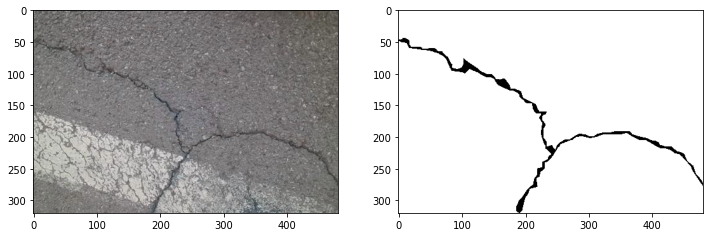

In [ ]:
i_sample = 21

image_path = os.path.join(IMAGES_FOLDER, f'{i_sample:03}.jpg')
mask_path = os.path.join(MASKS_FOLDER, f'{i_sample:03}.mat')

image = cv2.imread(image_path)
cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask_mat = io.loadmat(mask_path)

s1 = len(mask_mat['groundTruth'])
s2 = len(mask_mat['groundTruth'][0])
s3 = len(mask_mat['groundTruth'][0][0])
s4 = mask_mat['groundTruth'][0][0][0].shape

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.imshow(mask_mat['groundTruth'][0][0][0], cmap='binary')

s1, s2, s3, s4

In [ ]:
images_total = len(os.listdir(IMAGES_FOLDER))
masks_total = len(os.listdir(MASKS_FOLDER))

images_total, masks_total

(150, 113)

In [ ]:
mask_data = list()
for mask_filename in os.listdir(MASKS_FOLDER):
    mask_path = os.path.join(MASKS_FOLDER, mask_filename)
    mask_mat = io.loadmat(mask_path)
    mask_data.append(mask_mat['groundTruth'][0][0][0])
mask_data = np.array(mask_data)
mask_data.shape

(113, 320, 480)

In [ ]:
class CrackForestDataset(Dataset):
    def __init__(self, folder, transform):
        self.transform = transform
        self.data = list()
        images_folder = os.path.join(folder, 'images')
        masks_folder = os.path.join(folder, 'masks')
        for image_filename in os.listdir(images_folder):
            image_basename = image_filename.split('.')[0]
            image_path = os.path.join(images_folder, image_filename)
            mask_path = os.path.join(masks_folder, f'{image_basename}.mat')
            self.data.append((image_path, mask_path))
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_path, mask_path = self.data[index]

        image = cv2.imread(image_path)
        cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if os.path.exists(mask_path):
            mask = io.loadmat(mask_path)['groundTruth'][0][0][0]
        else:
            mask = np.zeros((320, 480), dtype=np.float32)

        if image.shape != (320, 480, 3):
            image = image.reshape(320, 480, 3)
        
        augmented = self.transform(image=image, mask=mask)

        augmented_image = augmented['image'].float() / 255.0
        augmented_mask = augmented['mask'].float().unsqueeze(0)

        return augmented_image, augmented_mask

In [ ]:
train_transform = A.Compose([
    # A.CoarseDropout(p=0.5, min_holes=5, max_holes=5, min_height=8, min_width=8, max_height=16, max_width=16),
    ToTensorV2()
])

In [ ]:
train_dataset = CrackForestDataset(DATA_FOLDER,transform=train_transform)

In [ ]:
train_dataset[0][1]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

#### Visualize data

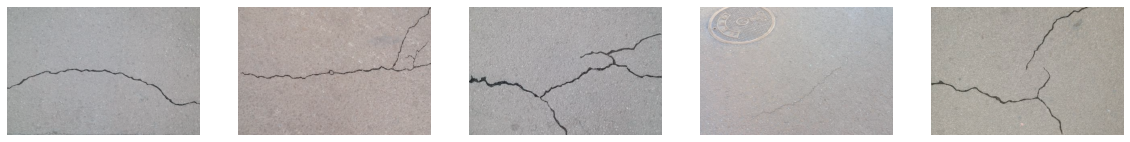

In [ ]:
first_batch = next(iter(DataLoader(train_dataset, batch_size=5)))
show_images(first_batch, show_mask=True, cmap='binary')

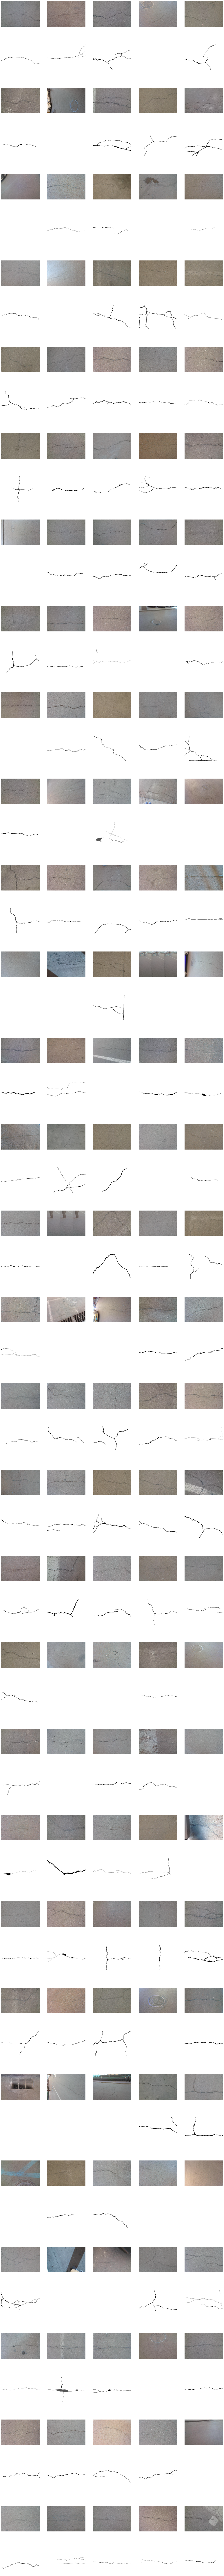

In [ ]:
full_dataset = next(iter(DataLoader(train_dataset, batch_size=len(train_dataset))))
show_images(full_dataset, show_mask=True, show_separate=True, n_max=len(train_dataset), cmap='binary')

## Split train/validation/test

In [ ]:
data_size = len(train_dataset)

test_split_i = int(data_size * 0.2)
val_split_i = test_split_i + int(data_size * 0.12)

data_indices = np.arange(data_size)
np.random.shuffle(data_indices)

test_indices = data_indices[:test_split_i]
val_indices = data_indices[test_split_i:val_split_i]
train_indices = data_indices[val_split_i:]

len(test_indices), len(val_indices), len(train_indices)

(30, 18, 102)

## Train

In [ ]:
def train_model(
    train_loader,
    val_loader,
    model,
    criterion,
    metric,
    optimizer,
    scheduler=None,
    epochs=5,
    session_name='Main',
    run_name='',
    silent_mode=False,
    metric_treshhold=0.0
):
    if run_name:
        wandb.init(project=PROJECT_NAME, name=run_name)

    loss_meter, metric_meter = MeanMetric(), MeanMetric()
    best_loss, best_metric = float('inf'), float('inf')

    for epoch in tqdm(range(1, epochs + 1), disable=silent_mode):
        # Train
        loss_meter.reset()
        metric_meter.reset()
        model.train()
        for X, y in train_loader:
            X_gpu = X.to(device)
            y_gpu = y.to(device)
            prediction = model(X_gpu)
            loss_value = criterion(prediction, y_gpu)
            metric_value = metric(prediction.sigmoid(), y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            loss_meter.update(loss_value.item())
            metric_meter.update(metric_value.item())
        
        train_loss, train_metric = loss_meter.compute(), metric_meter.compute()
        
        # Validation
        loss_meter.reset()
        metric_meter.reset()
        model.eval()
        with torch.no_grad():
            for X, y in val_loader:
                X_gpu = X.to(device)
                y_gpu = y.to(device)
                prediction = model(X_gpu)
                loss_value = criterion(prediction, y_gpu)
                metric_value = metric(prediction.sigmoid(), y_gpu)
                loss_meter.update(loss_value.item())
                metric_meter.update(metric_value.item())
        
        val_loss, val_metric = loss_meter.compute(), metric_meter.compute()

        # Learning rate annealing
        if scheduler is not None:
            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(train_loss)
            else:
                scheduler.step()

        # Log
        if not silent_mode:
            print(f'epoch: {epoch:<3}', end=' | ') 
            print(f'train_loss: {train_loss:.5f}', end=' | ')
            print(f'train_metric: {train_metric:.3f}', end=' | ')
            print(f'val_loss: {val_loss:.5f}', end=' | ')
            print(f'val_metric: {val_metric:.3f}')
        if run_name:
            wandb.log({
                'train_loss': train_loss,
                'train_metric': train_metric,
                'val_loss': val_loss,
                'val_metric': val_metric
            }, step=epoch)

        # Saving model checkpoint
        if val_loss < best_loss:
            best_loss = val_loss
            best_metric = val_metric
            torch.save(model, os.path.join(CHECKPOINTS_FOLDER, f'{session_name}.pt'))
        
        # Exiting if metric is low
        if val_metric < metric_treshhold:
            break
    
    if run_name:
        wandb.finish()

    if not silent_mode:
        print(f'\nbest_loss: {best_loss:.5f}, best_metric: {best_metric:.3f}')
    else:
        return best_loss.item(), best_metric.item()

In [ ]:
def get_best_model(checkpoints_folder, session_name):
    return torch.load(os.path.join(checkpoints_folder, f'{session_name}.pt'))

## Metrics

In [ ]:
class DiceScore(nn.Module):
    def __init__(self, smooth=1e-15):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, inputs, preds):
        
        inputs = inputs.flatten()
        preds = preds.flatten()

        intersection = (inputs * preds).sum()
        denominator = (inputs + preds).sum()
        dice = (2. * intersection + self.smooth) / (denominator + self.smooth)

        return dice


class IoUScore(nn.Module):
    def __init__(self, smooth=1e-15):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, inputs, preds):

        inputs = inputs.flatten()
        preds = preds.flatten()

        intersection = (inputs * preds).sum()
        union = (inputs + preds).sum() - intersection
        iou = (intersection + self.smooth) / (union + self.smooth)

        return iou


class Recall(nn.Module):
    def __init__(self, smooth=1e-15):
        super().__init__()
        self.smooth = smooth
        
    def forward(self, inputs, preds):

        inputs = inputs.flatten()
        preds = preds.flatten()

        TP = (inputs * preds).sum()
        FN = ((1 - inputs) * preds).sum()
        recall = (TP + self.smooth) / (TP + FN + self.smooth)

        return recall


class Precision(nn.Module):
    def __init__(self, smooth=1e-15):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, inputs, preds):

        inputs = inputs.flatten()
        preds = preds.flatten()

        TP = (inputs * preds).sum()
        FP = ((1 - preds) * inputs).sum()
        precision = (TP + self.smooth) / (TP + FP + self.smooth)

        return precision


class FBScore(nn.Module):
    def __init__(self, smooth=1e-15, beta=1.0):
        super(FBScore, self).__init__()
        self.smooth = smooth
        self.beta = beta
        self.precision = Precision()
        self.recall = Recall()
    
    def forward(self, inputs, preds):
        
        precision = self.precision(inputs, preds)
        recall = self.recall(inputs, preds)
        inter = ((1 + self.beta**2) * precision * recall) + self.smooth
        fb_score =  inter / (((self.beta**2) * precision) + recall + self.smooth)

        return fb_score

## Model, loss, optimizer

#### Data loaders

In [ ]:
batch_size = 8

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_indices)
)

val_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_indices)
)

#### Model

In [ ]:
encoder = 'resnet18'
lr = 1e-4
reg = 1e-3
session_name = 'Unet-1'
run_name = f'{encoder}/{lr}/{reg}/{batch_size}'

model1 = sm.Unet(
    encoder_name=encoder,
    encoder_weights='imagenet',
    activation='sigmoid',
    in_channels=3,
    classes=1
)
model1.to(device)
criterion = nn.BCEWithLogitsLoss()
metric = IoUScore()
optimizer = optim.Adam(model1.parameters(), lr=lr, weight_decay=reg)

In [ ]:
train_model(train_loader, val_loader, model1, criterion, metric, optimizer, epochs=10, session_name=session_name, run_name=run_name)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 1   | train_loss: 0.57830 | train_metric: 0.526 | val_loss: 0.61750 | val_metric: 0.493
epoch: 2   | train_loss: 0.55194 | train_metric: 0.542 | val_loss: 0.61036 | val_metric: 0.481
epoch: 3   | train_loss: 0.53818 | train_metric: 0.546 | val_loss: 0.58660 | val_metric: 0.512
epoch: 4   | train_loss: 0.52662 | train_metric: 0.554 | val_loss: 0.53026 | val_metric: 0.551
epoch: 5   | train_loss: 0.51480 | train_metric: 0.560 | val_loss: 0.51616 | val_metric: 0.561
epoch: 6   | train_loss: 0.51296 | train_metric: 0.560 | val_loss: 0.55806 | val_metric: 0.513
epoch: 7   | train_loss: 0.51028 | train_metric: 0.560 | val_loss: 0.58093 | val_metric: 0.505
epoch: 8   | train_loss: 0.49343 | train_metric: 0.571 | val_loss: 0.50711 | val_metric: 0.568
epoch: 9   | train_loss: 0.48968 | train_metric: 0.574 | val_loss: 0.55505 | val_metric: 0.509
epoch: 10  | train_loss: 0.48352 | train_metric: 0.577 | val_loss: 0.48710 | val_metric: 0.576

best_loss: 0.48710, best_metric: 0.576


## Predict

In [ ]:
def evaluate_model(dataset, model, indices):

    loader = DataLoader(dataset, batch_size=len(indices), sampler=SubsetRandomSampler(indices))
    X, y = next(iter(loader))

    model.eval()
    with torch.no_grad():
        X_gpu = X.to(device)
        preds = model(X_gpu)
    
    return X, y, preds.cpu()

In [ ]:
best_model = get_best_model(CHECKPOINTS_FOLDER, 'Unet-1')
inputs, outputs, preds = evaluate_model(train_dataset, best_model, val_indices)

In [ ]:
def clear_preds(preds, threshold):
    # preds[preds >= threshold] = 0.0
    # preds[preds < threshold] = 0.0
    preds[[preds < ]] = 1.0

In [ ]:
preds[preds > 0.95] = 1.0
preds[preds < 0.95] = 0.0

tensor(0.)


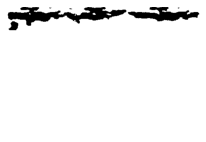

In [ ]:
show_images([preds[3]], cmap='binary')

print(preds[3][165][10])

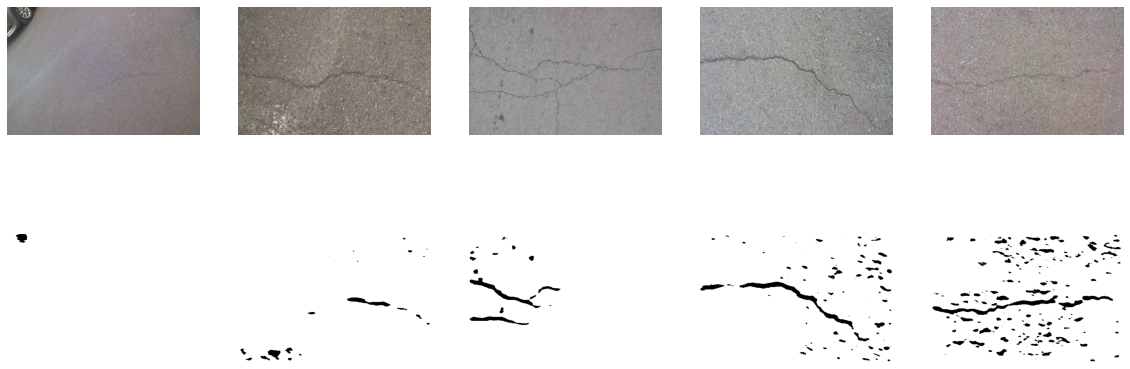

In [ ]:
show_images((inputs, preds), show_mask=True, show_separate=True, cmap='binary', shuffle=True)

In [ ]:
DiceScore()(outputs, preds).item()

0.7546100616455078

In [ ]:
IoUScore()(outputs, preds).item()

0.6059227585792542